# **Import libraries**

In [1]:
import fastai
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [3]:
path = Path('./models/')
model_pth = path / 'model.pkl' 
model=load_learner(model_pth)

In [7]:
type(model.predict(images/'R/R_1.jpg'))

tuple

In [5]:
path = Path('./DATASET/')

In [6]:
images = path / 'TRAIN' 

# **Creating a datablock and dataloader for train images**

In [8]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_items=get_image_files, 
                   get_y=parent_label,
                   item_tfms=Resize(256))

In [9]:
dl = db.dataloaders(images)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


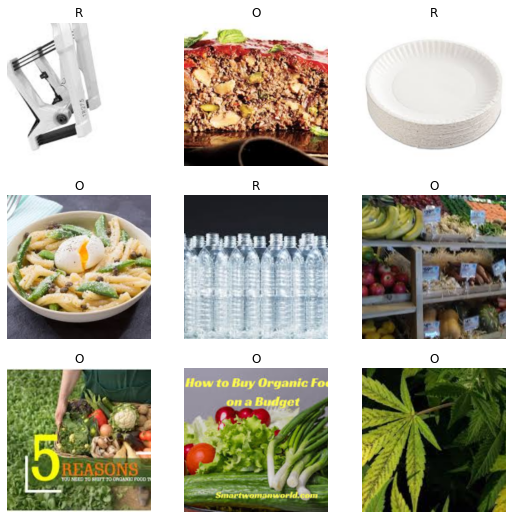

In [10]:
dl.show_batch(nrows=3, ncols=3)

# **Training**

First let's create a basic cnn model with fastai

In [11]:
model = cnn_learner(dl, resnet34, metrics=error_rate)
model.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.516240,0.446314,0.129433,02:58


epoch,train_loss,valid_loss,error_rate,time
0,0.305153,0.295384,0.089317,03:30


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.918309736647643e-06)

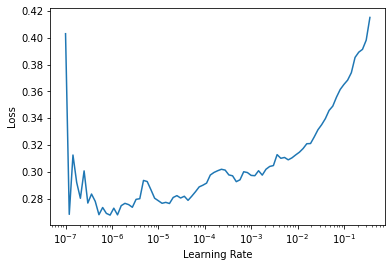

In [8]:
model.lr_find()

Now let's train a model specifying the suitable learning rate

In [9]:
model = cnn_learner(dl, resnet34, metrics=error_rate)
model.fine_tune(1, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.276926,0.161937,0.060949,02:34


epoch,train_loss,valid_loss,error_rate,time
0,0.130570,0.102407,0.039229,03:11


We've got a better error rate! Now let's train the final model and see if results improve a bit more. First, the model trains on randomly added layers for one epoch, with all other layers frozen. Then it unfreezes all the layers and  trains with *discriminative learning rates*. 

In [10]:
model = cnn_learner(dl, resnet34, metrics=error_rate)
model.fit_one_cycle(1, 2e-3)
model.unfreeze()
model.fit_one_cycle(8, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.183014,0.121687,0.043661,02:21


epoch,train_loss,valid_loss,error_rate,time
0,0.160559,0.115370,0.042110,02:55
1,0.138263,0.107332,0.038342,03:00
2,0.110457,0.103948,0.036569,02:55
3,0.076225,0.105127,0.036569,02:51
4,0.054847,0.104886,0.033910,02:52
5,0.042618,0.105265,0.034796,02:55
6,0.039474,0.106467,0.033910,02:50
7,0.036133,0.106245,0.033910,02:49


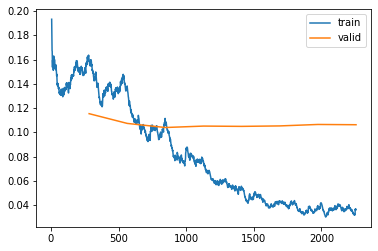

In [11]:
model.recorder.plot_loss()

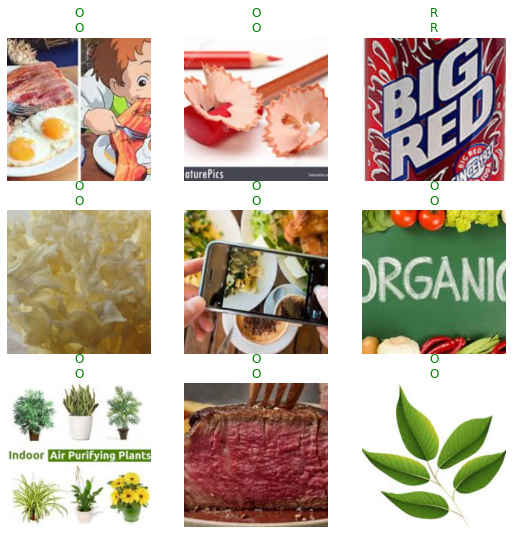

In [12]:
model.show_results()

In [13]:
interp = ClassificationInterpretation.from_learner(model)

In [15]:
interp.print_classification_report()

              precision    recall  f1-score   support

           O       0.97      0.97      0.97      2509
           R       0.96      0.96      0.96      2003

    accuracy                           0.97      4512
   macro avg       0.97      0.97      0.97      4512
weighted avg       0.97      0.97      0.97      4512



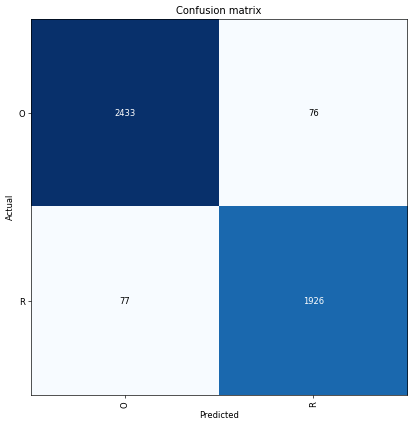

In [16]:
interp.plot_confusion_matrix(figsize=(9,7), dpi=60)

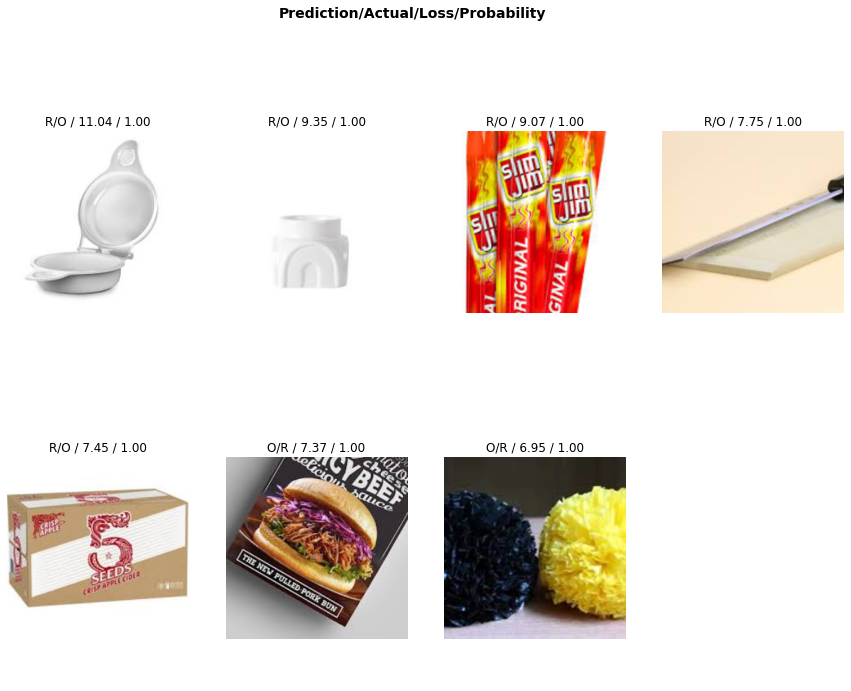

In [17]:
interp.plot_top_losses(7, figsize=(15,11))

# **Model performance on test set**

In [11]:
test = path/'TEST'
test.ls()

(#2) [Path('DATASET/TEST/O'),Path('DATASET/TEST/R')]

In [12]:
test_images = get_image_files(test)

In [13]:
test_db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                  get_y=parent_label,
                   item_tfms=Resize(256))

In [14]:
test_dl = test_db.dataloaders(test)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [15]:
tdl = test_dl.test_dl(test_images, with_labels=False)

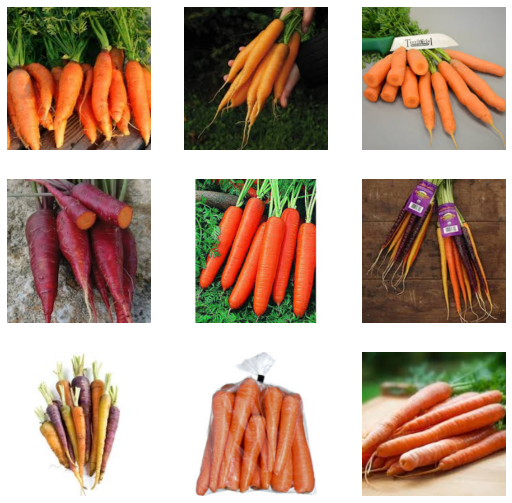

In [16]:
tdl.show_batch(nrows=3, ncols=3)

In [17]:
preds = model.get_preds(dl=tdl)

In [18]:
predictions = torch.argmax(preds[0], dim=1)
test_labels = torch.Tensor([1 if i.name[0] == 'R' else 0 for i in test_images])
accuracy = round((test_labels == predictions).float().mean().item()*100,1)
print(f'Accuracy on test set {accuracy}%')

Accuracy on test set 47.6%
